Mounted at /content/drive


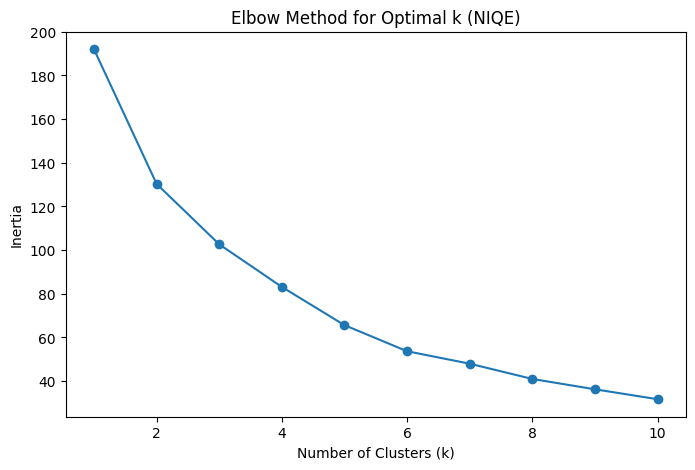

Feature Importance Ranking (Random Forest - NIQE):
Aperture_Size           0.651159
Working_Distance        0.209080
Accelerating_Voltage    0.139761
dtype: float64


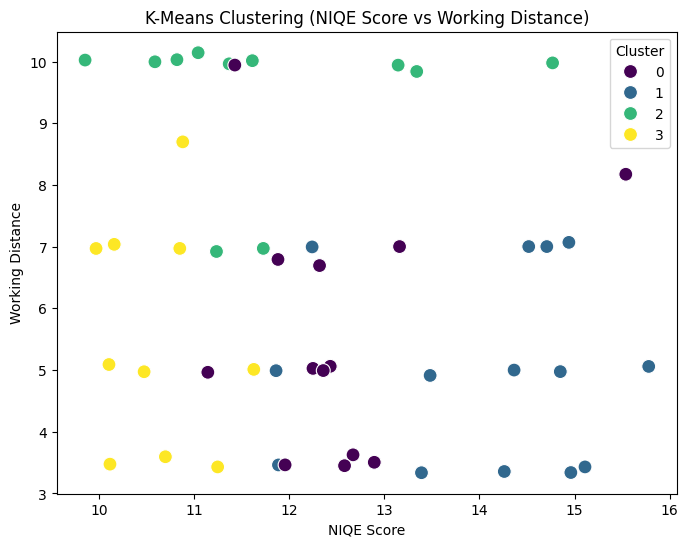

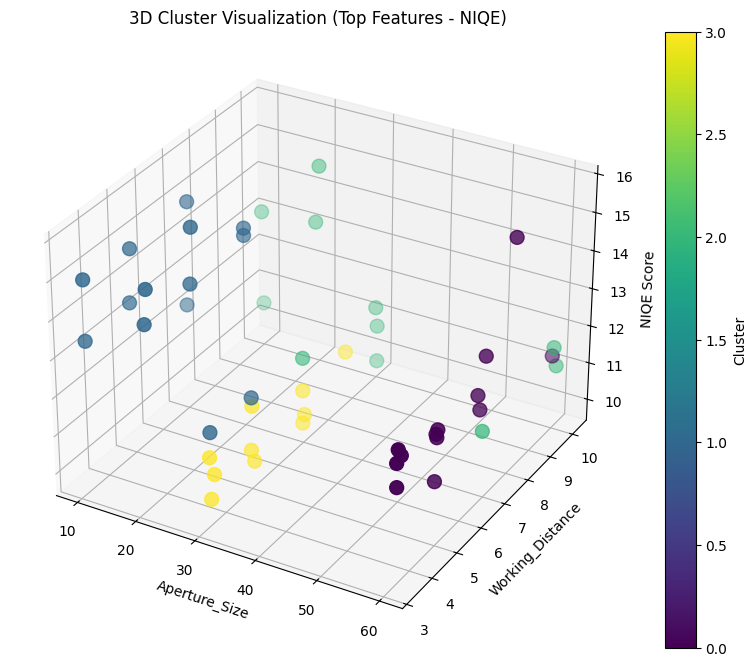

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/EOD_2_SN/SN/niqe_scores_with_metadata.csv')

# Rename columns for simplicity
data = data.rename(columns={
    'ap_aperturesize': 'Aperture_Size',
    'ap_wd': 'Working_Distance',
    'ap_actualkv': 'Accelerating_Voltage',
    'Score': 'NIQE_Score'
})

# Keep only relevant numeric columns for analysis
data_cleaned = data[['Aperture_Size', 'Working_Distance', 'Accelerating_Voltage', 'NIQE_Score']]

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)

# Elbow method to determine optimal k
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (NIQE)')
plt.show()

# Based on elbow plot
optimal_k = 4

# K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data_scaled)
data['Cluster'] = clusters

# Feature importance using Random Forest
X = data_cleaned.drop(columns=['NIQE_Score'])
y = data_cleaned['NIQE_Score']

model = RandomForestRegressor(random_state=42)
model.fit(X, y)
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# Display feature importance
print("Feature Importance Ranking (Random Forest - NIQE):")
print(feature_importances.sort_values(ascending=False))

# 2D Cluster visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=data['NIQE_Score'],
    y=data['Working_Distance'],
    hue=data['Cluster'],
    palette='viridis',
    s=100
)
plt.xlabel('NIQE Score')
plt.ylabel('Working Distance')
plt.title('K-Means Clustering (NIQE Score vs Working Distance)')
plt.legend(title='Cluster')
plt.show()

# 3D Plot using top 2 important features + NIQE
top_features = feature_importances.nlargest(2).index.tolist()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    data[top_features[0]],
    data[top_features[1]],
    data['NIQE_Score'],
    c=data['Cluster'],
    cmap='viridis',
    s=100
)

ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.set_zlabel('NIQE Score')
ax.set_title('3D Cluster Visualization (Top Features - NIQE)')
plt.colorbar(scatter, label='Cluster')
plt.show()
